In [1]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=2)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 15 (delta 8), pack-reused 569
Receiving objects: 100% (653/653), 62.41 MiB | 18.69 MiB/s, done.
Resolving deltas: 100% (335/335), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.35.2
Using datasets v2.15.0
Using accelerate v0.25.0
Using sentencepiece v0.1.99
Using umap v0.5.5


# 2. 텍스트 분류
##### 텍스트 분류는 NLP에서 일반적인 작업이다. 고객 피드백을 어떤 카테고리로 분류하거나 언어에 따른 다른 처리를 하는 작업 등 매우 다양한 어플리케이션에 사용한다.
##### 또 다른 일반적인 텍스트 분류 작업은 감성 분석이다. 주어진 텍스트의 감성 상태를 식별하는 것이 목적이다.
##### 이 장에서는 BERT의 한 종류인 DistilBERT를 사용해 감성 상태를 인식하는 시스템을 다룰 것이다. 이 모델은 BERT에 비견할만한 성능을 내지만 훨씬 작고 효율적이다.
##### 만약 대규모 BERT 모델을 훈련해야 한다면 간단히 사전 훈련된 모델의 **체크포인트**를 바꾸면 된다.

* 체크포인트 : 트랜스포머 아키텍처로 로드되는 일련의 가중치

##### 또, 해당 예제에서 허깅페이스 생태계의 핵심 라이브러리인 데이터셋, 토크나이저, 트랜스포머스를 사용해보자
##### 원시 데이터에서 시작해 새로운 트윗에서 추론을 수행하는 미세 튜닝된 모델을 만들어보자
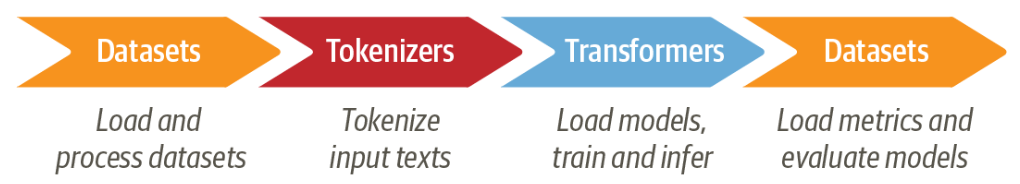

## 2.1 데이터셋
##### 감정 감지기를 개발하기 위해 영어로 작성된 트위터 메시지에 감정이 어떻게 표현되는지 연구한 논문의 데이터셋을 사용한다.
##### 이 데이터셋은 분노(anger), 혐오(disgust), 두려움(fear), 기쁨(joy), 슬픔(sadness), 놀람(surprise)의 여섯 개 감정으로 나뉜다. 트윗이 주어지면 여섯 개의 감정 중 하나로 분류하는 모델을 훈련을 진행한다.

### 2.1.1 허깅페이스 데이터셋 처음 사용하기


In [2]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있습니다.")
print(f"처음 10개 데이터셋 {all_datasets[:10]}")

<ipython-input-2-a4e058fa2927>:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


현재 허브에는 83788개의 데이터셋이 있습니다.
처음 10개 데이터셋 ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa',
'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue',
'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

##### 이는 Dataset 클래스 객체를 반환한다. Dataset 객체는 데이터셋의 핵심 데이터 구조 중 하나다.
##### 평범한 파이썬 배열이나 리스트처럼 동작한다.

In [6]:
len(train_ds)

16000

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [8]:
train_ds.column_names

['text', 'label']

##### 이 딕셔너리의 값은 트윗과 감정에 해당한다. 이는 허깅페이스 데이터셋이 아파치 에로우를 기반으로 한다는 것이다.
* 아파치 에로우 : 기본 파이썬보다 훨씬 더 메모리 효율적인 열 기반 포맷
##### 사용 중인 데이터 타입은 Dataset 객체의 features 속성에 표시된다.

In [9]:
 print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [10]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


### 허브에 필요한 데이터셋 없다면 ?
##### 포맷에 따라 데이터셋 로딩 방법이 아래와 같다.
##### csv, text, json -> load_dataset("csv" or "text" or "json", data_files = "my_files.csv" or "my_files.txt" or "my_files.json")

In [11]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

--2023-12-05 05:41:55--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 3.163.189.114, 3.163.189.90, 3.163.189.74, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.58M  5.03MB/s    in 0.3s    

2023-12-05 05:41:56 (5.03 MB/s) - ‘train.txt’ saved [1658616/1658616]



In [12]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


In [13]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";",
                              names=["text", "label"])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [14]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";",
                               names=["text", "label"])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

### 2.1.2 데이터셋에서 데이터프레임으로
##### 허깅페이스의 저수준 기능을 사용해서 데이터를 분석해도 되지만, 판다스의 DataFrame으로 출력 포맷을 변경하여 처리도 가능하다.

In [15]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [16]:
def label_int2str(row):
  # int2str : 정수 레이블을 클래스 이름으로 바꿔주는 메서드 / str2int도 존재
  return emotions['train'].features["label"].int2str(row)

df["label_name"] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 2.1.3 클래스 분포 살펴보기
##### 텍스트 분류 문제를 다룰 때는 샘플의 클래스 분포를 조사해야 한다. 만약 클래스 분포가 편향된 데이터셋은 훈련 손실과 평가 지표 측면에서 균형 잡힌 데이터셋과 다른 처리법이 필요하다.

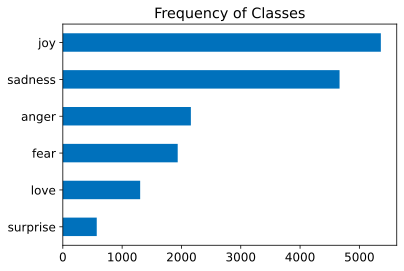

In [18]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

##### 데이터셋이 불균형하다. 데이터셋이 불균형할 때, 아래와 같은 방법으로 다룬다.
##### * 소수 클래스를 랜덤하게 오버샘플링 진행
##### * 다수 클래스를 랜덤하게 언더샘플링 진행
##### * 클래스의 대표성이 부족하다면 레이블링된 데이터를 더 많이 수집

##### 이 장에서는 간단하게 불균형한 클래스 분포를 그대로 사용할 것이다.
##### 샘플링 기법을 사용할 때는 훈련 세트에만 사용해야 한다. 그렇지 않으면 훈련/테스트 분할 사이에 많은 정보가 빠져나간다.

* 샘플링 기법 : imbalanced-learn 라이브러리 참고

### 2.1.4 트윗 길이 확인
##### 트랜스포머 모델은 **최대 문맥 크기**라는 최대 입력 시퀀스 길이가 있다.
##### DistilBERT를 사용하는 어플리케이션에서 최대 문맥 크기는 512 토큰으로 문단 몇 개 정도가 된다.
##### 토큰은 텍스트의 기본 단위이고, 여기서는 토큰을 단어로 간주한다.

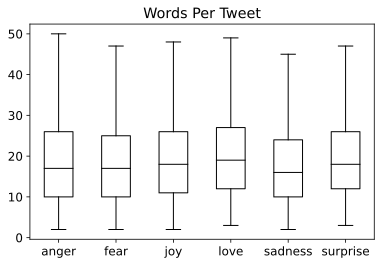

In [19]:
df['Words Per Tweet'] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

##### 그래프를 보면 각 감정의 트윗 길이는 15개 단어 정도이고, 가장 긴 트윗도 50개 정도이다. 텍스트가 모델의 문맥 크기보다 길면 짤라야 하는데 다행이도 해당 데이터셋은 그럴 필요가 없다.
##### 이제 원시 텍스트를 허깅페이스 트랜스포머스에 적합한 포맷으로 변경하자
##### 더 이상 DataFrame 포맷이 필요하지 않으니 데이터셋의 출력 포맷을 초기화하자

In [20]:
emotions.reset_format()

## 2.1 텍스트에서 토큰으로
##### DistilBERT 같은 트랜스포머 모델은 원시 문자열을 입력으로 받지 못한다. 대신 텍스트가 토큰화되어 수치 벡터로 인코딩 되었다고 해보자
* 토큰화 : 문자열을 모델이 사용하는 기본 단위로 분할하는 단계

##### 적용할 수 있는 토큰화 전략이 몇 가지 있으며 단어를 부분 단위로 나누기 위한 최적 분할은 일반적으로 말뭉치에서 학습된다. 문자 토큰화와 단어 토큰화를 살펴본 후 DistilBERT에서 사용하는 토크나이저에 대해 알아보자

### 2.2.1 문자 토큰화
##### 가장 간단한 토큰화는 각 문자를 개별로 모델에 주입하는 것이다.

In [24]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


##### 각 문자를 정수로 변환시키는 **수치화** 작업을 수행한다.
##### 가장 손쉬운 방법은 고유한 각 토큰을 고유한 정수로 인코딩하는 것이다.

In [25]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


##### 이를 통해 어휘사전에 있는 각 문자를 고유한 정수로 바꾸는 매핑 딕셔너리를 만들자
##### 이제 token2idx를 사용해 토큰화된 텍스트를 정수 리스트로 변환한다.

In [26]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


##### 각 토큰이 고유한 숫자 식별자로 매핑되었다. 마지막 단계로 input_ids를 원-핫 벡터의 2D 텐서로 바꾼다.
* 원-핫 벡터 : 머신러닝에서 순서형 또는 명목형 범주 데이터를 인코딩하기 위해 자주 사용된다.

In [27]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


##### 이 방식은 이름 사이에 가상의 순서가 만들어진다는 문제가 있다. 신경망은 이런 종류의 관계를 학습하는 능력이 뛰어나다
##### 따라서 이 대신 범주마다 새 열을 만들어 이름이 범주에 해당하면 1, 아니면 0을 할당하자.
##### 판다스에 get_dummies() 활용

In [29]:
pd.get_dummies(categorical_df['Name'])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


##### 해당 DataFrame의 행이 원-핫 벡터이다.
##### 다음처럼 파이토치로 input_ids를 텐서로 바꾸고 one_hot() 함수를 사용해 원-핫 인코딩을 만들어보자

In [30]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

##### 38개의 입력 토큰에 각각에 20차원의 원-핫 벡터가 만들어졌다. 어휘사전을 구성하는 고유한 문자가 20개이기 때문이다.
##### ont_hot() 함수에서 num_classes 매개변수를 지정하는 것이 중요하다! 원-핫 벡터가 어휘사전보다 더 짧아질 수도 있기 때문이다. -> 텐서플로는 tf.one_hot() depth

In [31]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


##### 문자 수준의 토큰화는 텍스트의 구조를 무시하고 전체 문자열을 문자 스트림으로 처리한다. 해당 방식은 철자 오류나 희귀한 단어를 처리하는데 유용하다.
##### 하지만, 단어 같은 언어 구조를 해당 데이터에서 학습해야 하고, 큰 리소스가 든다.
##### 실제로 문자 수준의 토큰화는 잘 사용되지 않고, 텍스트의 구조를 유지할 수 있는 **단어 토큰화**를 많이 사용한다.

### 2.2.2 단어 토큰화
##### 텍스트를 문자가 아닌 단어로 분할하고 각 단어를 정수로 매핑한다. -> 훈련 과정의 복잡도 감소

In [32]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


##### 구두점이 고려되지 않아서 NLP.이 하나의 토큰으로 처리된다. 단어에 곡용, 활용형, 철자 오류가 포함되어 어휘사전이 금세 수백만 개까지 늘어날 수 있다.
##### 어휘사전이 크면 신경망의 파라미터 역시 많이 필요해져 문제가 된다.
##### 예를 들어, 100만 개의 고유한 단어가 있고, 이 100만 차원의 입력 벡터를 신경망의 첫 번째 층에서 1000차원의 벡터로 압축한다고 가정하자. 그럼 첫 번째 층의 가중치 행렬은 100만개 X 1000개 = 10억 개의 가중치를 가진다.
##### 모델 파라미터가 낭비되는건 피해야 한다. -> 어휘사전의 크기를 제한하자 -> 자주 등장하지 않는 단어들은 UNK 토큰으로 매핑하자 -> 토큰화 과정에서 중요한 정보를 잃어버릴 수도 있다.
##### 모든 입력 정보와 일부 입력 구조를 유지하는 문자 토큰화와 단어 토큰화를 절충하는 방법인 **부분단어 토큰화**를 사용하자!

### 2.2.3 부분단어 토큰화
##### 부분단어 토큰화는 기본적으로 문자 토큰화와 단어 토큰화의 장점을 결합한 방법이다.
##### 드물게 등장하는 단어를 더 작은 단위로 나누면 모델이 복잡한 단어나 철자 오류를 처리하기 용이하다.
##### 다른 한편으로는 입력 길이를 적절한 크기로 유지하기 위해 자주 등장하는 단어를 고유한 항목으로 유지한다.
##### 부분단어 토큰화는 통계 규칙과 알고리즘을 함께 사용해 사전 훈련 말뭉치에서 학습한다.

##### NLP 분야에서 널리 사용되는 부분단어 토큰화 중 먼저 BERT와 DistilBERT의 토크나이저로 사용된 WordPiece를 사용해보자

In [33]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

##### AutoTokenizer 클래스는 체크포인트 이름을 사용해 모델의 설정, 사전 훈련된 가중치, 어휘 사전을 자동으로 추출해주는 '자동 클래스'이다.
##### 이 클래스를 사용하면 모델 간의 빠른 전환이 가능하지만, 특정 클래스를 수동으로 로드할 수도 있다.

In [34]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

##### * 처음 메서드를 실행하면 허깅페이스 허브에서 로딩하는 과정을 보여주는 진행 줄이 나타난다. 그러나 두번째 실행부터는 캐시로부터 토크나이저를 로드한다. 보통 캐시 위치는 ~/.cache/huggingface 이다

In [35]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


##### attention_mask 필드의 역할은 다음 절에서 소개한다.
##### 일단, input_ids가 있으므로 토크나이저의 convert_ids_to_tokens() 메서드를 사용해 토큰으로 변환하자

In [36]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


##### 정리
##### 1. 특수 토큰 [CLS]와 [SEP]가 끝에 추가 되었다. 이런 토큰은 모델마다 다르지만 주요 역할은 시퀀스의 시작과 끝을 의미한다.
##### 2. 토큰이 모두 소문자로 변경되었다.
##### 3. 'tokenizing'과 'NLP'가 각각 두 개의 토큰으로 나뉘었다. #은 앞의 문자열이 공백이 아님을 의미한다.

In [37]:
# 접두사가 붙은 토큰은 문자열과 함께 합친다.
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [38]:
# 어휘사전의 크기
print(tokenizer.vocab_size)

30522


In [39]:
# 모델의 최대 문맥 크기
print(tokenizer.model_max_length)

512


In [40]:
# 필드 이름
print(tokenizer.model_input_names)

['input_ids', 'attention_mask']


##### 사전 훈련된 모델을 사용할 때, 모델 훈련에 사용한 것과 동일한 토크나이저를 사용하는 것이 정말 중요하다.

### 2.2.4 전체 데이터셋 토큰화하기
##### 전체 말뭉치를 토큰화하기 위해 DatasetDict 객체의 map() 메서드를 사용하자.

In [41]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

##### 이 함수는 토크나이저를 샘플 배치에 적용한다.
##### padding=True로 지정하면 배치에 있는 가장 긴 샘플 크기에 맞춰 샘플을 0으로 패딩한다.
##### truncation=True로 설정하면 모델의 최대 문맥 크기에 맞춰 샘플을 잘라낸다.

In [42]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


##### 결과
##### input_ids의 첫 번째 원소가 두 번째보다 더 짧으므로, 길이를 동일하게 맞추기 위해 끝에 0을 추가했다. 0은 어휘사전에 있는 [PAD] 토큰에 해당한다.
##### 토크나이저는 인코딩된 트윗을 input_ids로 반환하고, attention_mask 배열 리스트도 반환한다. 추가된 패딩 토큰 때문에 모델이 혼동하지 않게 하는 조치이다.
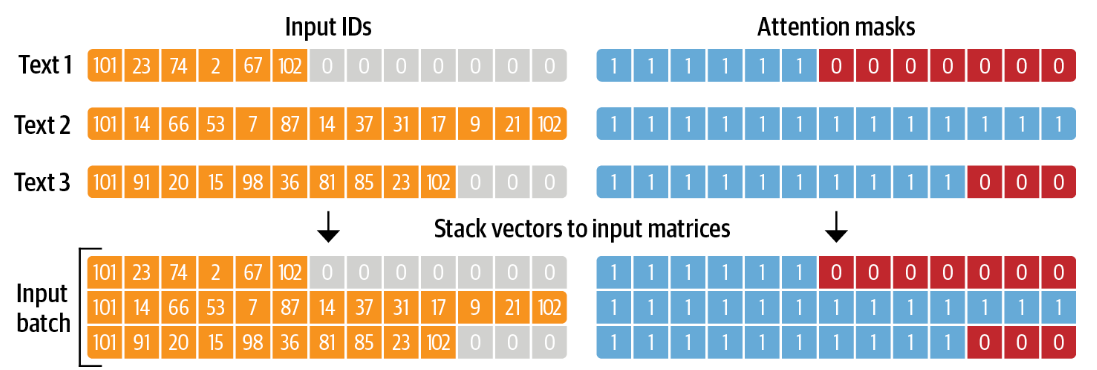

In [43]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

##### 기본적으로 map() 메서드는 말뭉치에 있는 모든 샘플에 개별적으로 적용하므로, batched=True로 설정하여 트윗을 배치로 인코딩한다.
##### 그리고 batch_size=None으로 설정했기 때문에 전체 데이터셋이 하나의 배치로 tokenize() 함수에 적용된다. 이렇게 하면 입력 텐서와 어텐션 마스크는 전역적으로 동일한 크기로 생성된다. 또 해당 연산은 데이터셋에 input_ids와 attention_maks 열을 새로 추가한다.

In [44]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']
